In [2]:
import re
import nltk
import spacy
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize 

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm
from wordcloud import WordCloud

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english') 

nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ritikagupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Loading the Dataset
df = pd.read_csv("tweets.csv",encoding='latin',header=None,on_bad_lines='skip')
# Renaming the column
df.rename(columns = {0:'labels',5:'tweets'},inplace=True)
# Drop the remaining column
df.drop([1,2,3,4],axis=1,inplace=True)

# Shuffling the dataset
df = df.sample(frac=1)
# Take a sample of 10000 tweets
df = df.head(10000)

# Replacing label '4': positive_sentiment with '1'
# Such that labels : 1 - Positive sentiment, 2 : Negative sentiment
df['labels'] = df['labels'].replace(4,1)
df.head()

labels                                             tweets
1101372       1  @sarahmaclean oh sorry! you gonna be around i ...
1267042       1  I had a big family too..6 all are adults now  ...
722449        0  I'm like diobok&quot;. My uncle is a bad drive...
116698        0  artsposure in Raleigh NC- today is rainy and v...
788609        0  @fairygem That story ends in an unexpected way...

In [4]:
# Count of postive and negative tweets
df['labels'].value_counts()

0    5013
1    4987
Name: labels, dtype: int64

In [5]:
# Checking for null value
df.isnull().sum()

labels    0
tweets    0
dtype: int64

### 1. Data Cleaning

In [6]:
df['tweets'].values[0]

'@sarahmaclean oh sorry! you gonna be around i have like a crap ton! or i can always mail you one with some comics and stuff '

In [7]:
def get_word_len(tweet):
    return len(tweet.split(' '))

def get_char_len(tweet):
    return len(tweet)

def preprocessed_tweet(tweet):
    # Convert the tweet to lowercase
    tweet = tweet.lower()
    # Remove URLs from the tweet
    tweet = re.sub(r"http\S+|www|S+|https\S+",'',tweet,flags = re.MULTILINE)
    # Remove mentions (e.g., @username) from the tweet
    tweet = re.sub(r'@\w+','',tweet)
    # Remove special characters and punctuation from the tweet
    tweet = re.sub(r'^\w\s#','',tweet)
    
    # Lemmatize the words using spaCy
    tokens = [token.lemma_ for token in nlp(tweet)]
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Remove single-character tokens
    tokens = [token for token in tokens if len(token)>1]
    # Join the processed tokens to form the cleaned tweet
    preprocessed_tweet = ' '.join(tokens)
    
    return preprocessed_tweet
# Apply the preprocess_tweet function to each tweet in the dataframe
df['clean_tweets'] = [preprocessed_tweet(tweet) for tweet in tqdm(df['tweets'],position=0,leave=True)]
# Calculate the number of words in each cleaned tweet and store it in a new column
df['tweet_words_length'] = df['clean_tweets'].apply(get_word_len)
# Calculate the number of characters in each cleaned tweet and store it in a new column
df['tweets_char_length'] = df['clean_tweets'].apply(get_char_len)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:11<00:00, 139.15it/s]


In [8]:
df.head()

labels                                             tweets  \
1101372       1  @sarahmaclean oh sorry! you gonna be around i ...   
1267042       1  I had a big family too..6 all are adults now  ...   
722449        0  I'm like diobok&quot;. My uncle is a bad drive...   
116698        0  artsposure in Raleigh NC- today is rainy and v...   
788609        0  @fairygem That story ends in an unexpected way...   

                                              clean_tweets  \
1101372  oh sorry go around like crap ton always mail o...   
1267042                             big family .. adult â   
722449   like diobok&quot uncle bad driver relize sit back   
116698   artsposure raleigh nc- today rainy much many s...   
788609   story end unexpected way decisde shoe yet sure...   

         tweet_words_length  tweets_char_length  
1101372                  12                  66  
1267042                   5                  22  
722449                    8                  49  
116698                   11                  68  
788609                   15                  83

### 2. Exploratory Data Analysis (EDA) on Text Data

In [9]:
# Checking the distribution of data i.e no of classes in positive or negative sentiment
positive_count = len(df[df['labels']==1])
negative_count = len(df[df['labels']==0])

# Create a pie chart using Plotly Express to visualize the distribution of positive and negative tweets
fig = px.pie(values = [positive_count,negative_count], title = 'Distribution of Positive and Negative Sentiments of the Tweets',
                 names = ['Positive','Negative'], hover_name=['Positive','Negative'],opacity = 0.9, template ='simple_white')
fig.show()


#### Creating Word Cloud

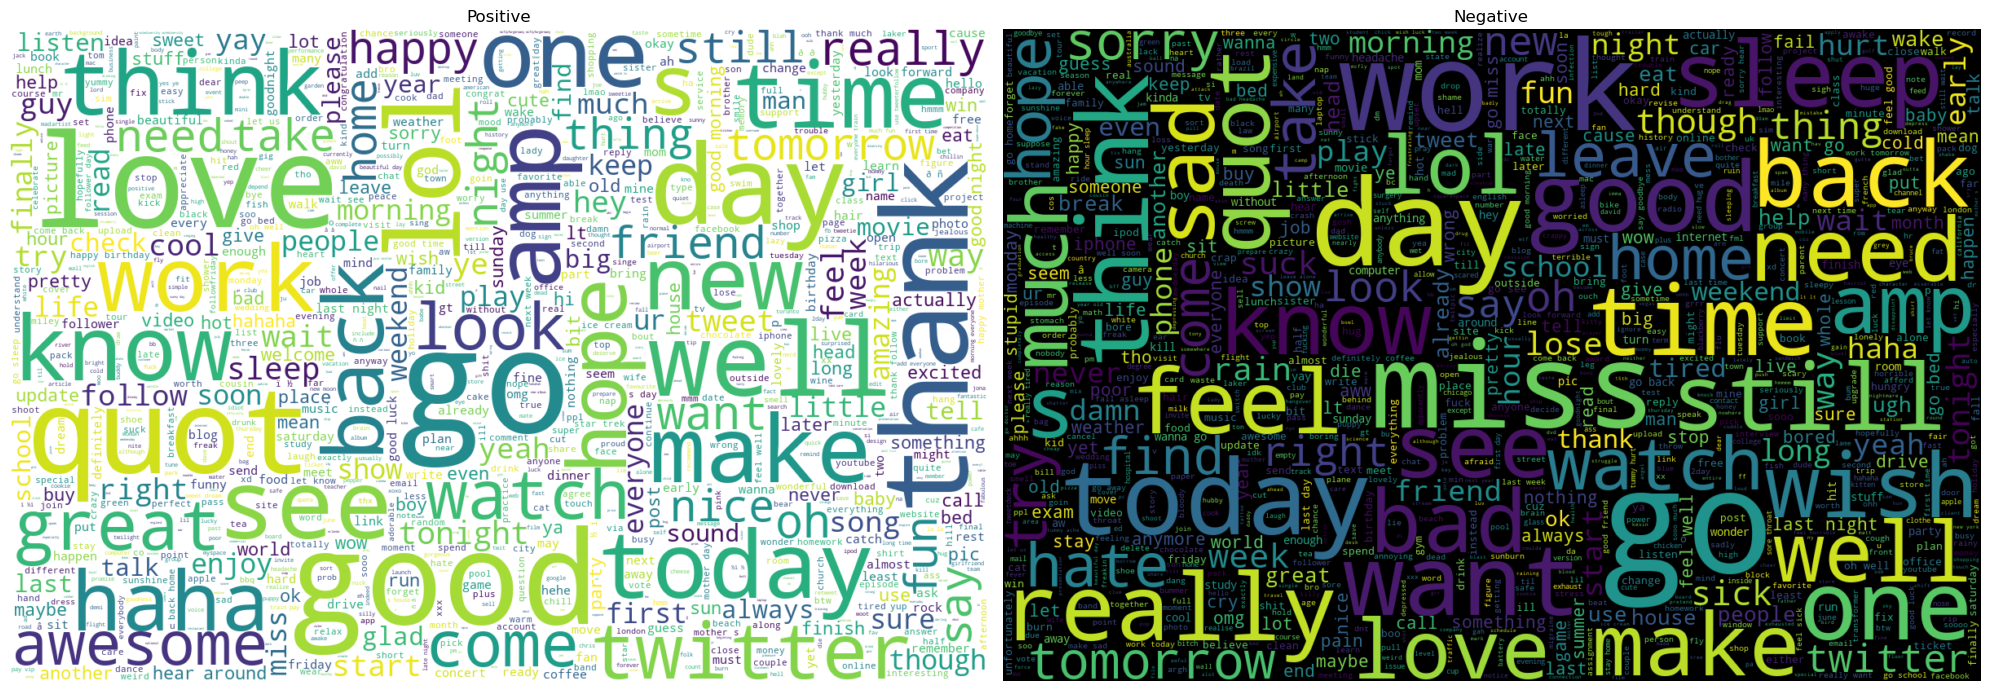

In [10]:
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)

# Generate and display a WordCloud for positive tweets
wordcloud_1 = WordCloud(width=1200,height=800,max_words=1000,contour_width = 2,
                         background_color='white', max_font_size=180, 
                         colormap = 'viridis').generate(' '.join(df[df['labels'] == 1]['clean_tweets']))
plt.imshow(wordcloud_1, interpolation = 'bilinear')
plt.axis('off')
plt.title('Positive')

plt.subplot(1,2,2)

# Generate and display a WordCloud for negative tweets
wordcloud_2 = WordCloud(width=1200,height=800,max_words=1000,contour_width = 2,
                         background_color='black', max_font_size=180, 
                         colormap = 'viridis').generate(' '.join(df[df['labels'] == 0]['clean_tweets']))
plt.imshow(wordcloud_2, interpolation = 'bilinear')
plt.axis('off')
plt.title('Negative')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Word Frequency Distribution

In [11]:
# Create distribution plots for word count and character count for positive and negative tweets

fig_words = ff.create_distplot([df[df['labels']==1]['tweet_words_length'], df[df['labels']==0]['tweet_words_length']],
                               ['Positive','Negative'],bin_size = 25, show_hist = False, show_rug = False)

fig_chars = ff.create_distplot([df[df['labels']==1]['tweets_char_length'], df[df['labels']==0]['tweet_words_length']],
                               ['Positive','Negative'],bin_size = 25, show_hist = False, show_rug = False)

# Set titles and labels for the distribution plots
fig_words.update_layout(title='Distribution of Words Count', xaxis_title='No of words', yaxis_title='Frequency')
fig_chars.update_layout(title='Distribution of Character Count', xaxis_title='No of characters', yaxis_title='Frequency')

# Combine the plots in a 2-column layout
fig = make_subplots(rows =1 , cols =2, subplot_titles = ['Word Count', 'Character Count'])
fig.add_trace(fig_words['data'][0], row=1,col =1)
fig.add_trace(fig_words['data'][1], row=1,col =1)
fig.add_trace(fig_chars['data'][0], row=1,col =2)
fig.add_trace(fig_chars['data'][1], row=1,col =2)

# Update overall layout and show the plot
fig.update_layout(title_text = 'Distribution Plots for Word and Character Count of the tweets',showlegend=True,
                 font = dict(family = 'Arial',size=15, color='black'))
fig.show()

### 3. Splitting the Dataset

In [12]:
X_train,X_test,y_train,y_test = train_test_split(df['clean_tweets'], df['labels'], test_size=0.2,random_state=42)
X_test , X_val, y_test, y_val = train_test_split(X_test,y_test,test_size = 0.5)

# Creating a pie chart to visualize the distribution of tweet counts in training, testing, and validation sets
fig = px.pie(values = [len(X_train), len(X_test), len(X_val)],title='Distribution of Training Testing and Validation Tweets',
                                        names = ['Training','Testing','Validation'], hover_name = ['Training','Testing','Validation'],
                                        opacity =.9,template = 'simple_white')
fig.show()

### Creating the Dataset for Neural Network

In [13]:
df = pd.read_csv("tweets.csv",encoding='latin',header=None,on_bad_lines='skip')
df.rename(columns = {0:'labels',5:'tweets'},inplace=True)
df.drop([1,2,3,4], axis=1 , inplace =True)
df['labels'] = df['labels'].replace(4,1)

df = df.sample(frac=1)
df = df.head(20000)

df['clean_tweets'] = [preprocessed_tweet(tweet) for tweet in tqdm(df['tweets'], position =0,leave=True)]
df['tweet_words_length'] = df["clean_tweets"].apply(get_word_len)
df['tweets_char_length'] = df["clean_tweets"].apply(get_char_len)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:42<00:00, 123.39it/s]


In [14]:
df.head()

labels                                             tweets  \
213977        0  Omg. Listening to this song reminded me of you...   
163846        0  @RedBaff alright - was only joking - I just sa...   
1238353       1  GUESS WHAT?! I'm back  I feeeel like me..  hap...   
597726        0  @apesss i'm sorry i'm an old person and though...   
1280434       1  @airliebird58 True but we would look so glamor...   

                                              clean_tweets  \
213977                       omg listen song remind lt;/33   
163846   alright joke say wine fool maybe don;t like drink   
1238353  guess back feeeel like .. happpyyy long sad ah...   
597726   sorry old person think take vicam bad friend o...   
1280434  true would look glamorous think get gok wan dr...   

         tweet_words_length  tweets_char_length  
213977                    5                  29  
163846                    9                  49  
1238353                  14                  71  
597726                   11                  58  
1280434                  11                  61

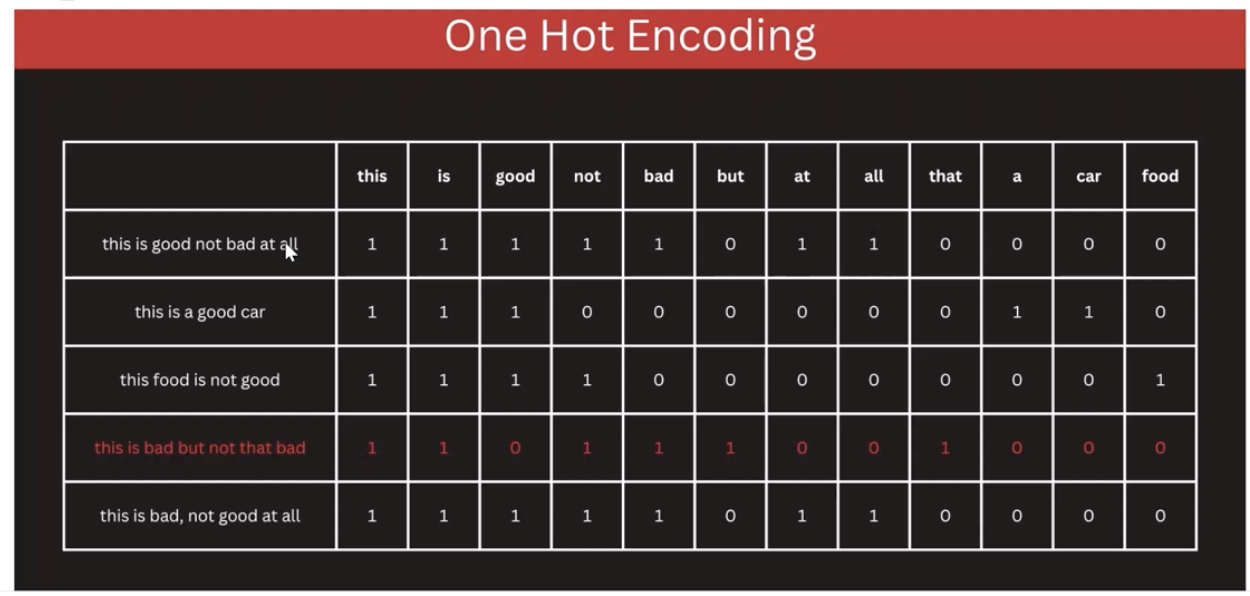

In [64]:
from IPython.display import Image

image = Image(filename='OneHotEncoding.png')
display(image)

### 1. Neural Network with One Hot Encoding

In [18]:
epochs_ = 1
batch_size_ = 32

In [19]:
# binary = True : Take it as One-Hot Encoder

# Using CountVectorizer with binary encoding for tweets
vec = CountVectorizer(binary = True)
vec = vec.fit(df['clean_tweets'])

# Transforming and converting tweets into arrays
enc_tweets = vec.fit_transform(df['clean_tweets']).toarray()

X_train,X_test, y_train,y_test = train_test_split(enc_tweets, df['labels'], test_size=0.2, random_state=42)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5)


# Building a neural network model with multiple dense layers and dropout for regularization
model = Sequential()
model.add(Dense(512,activation = 'relu', input_shape = (enc_tweets.shape[1], )))
model.add(Dropout(.5))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(1,  activation = 'sigmoid'))

# Compiling the model using binary crossentropy loss and Adam optimizer with a specified learning rate
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

# Batch_size : How many tweets you want to pass to neural network at a time
history_1 = model.fit(X_train,y_train,epochs = epochs_, batch_size=batch_size_,validation_data = (X_val,y_val))

500/500 [==============================] - 14s 28ms/step - loss: 0.5975 - accuracy: 0.6779 - val_loss: 0.5444 - val_accuracy: 0.7405


In [20]:
X_train.shape # 16000 tweets each tweet reprsented in a vector of 18053 (vocabulary size)

(16000, 17859)

In [21]:
#training   = 16000 /(32) =  500 batches
#testing    = 2000 (63 steps)
#validation = 2000 (63 steps)

model.evaluate(X_test,y_test)

# 63 steps * 32 = 2016 nearly tweets

63/63 [==============================] - 1s 8ms/step - loss: 0.5250 - accuracy: 0.7500


[0.5250265002250671, 0.75]

### 2. Neural Network with Count Vectorizer

* Count Vectorizer is used to convert raw text data into a numerical format by counting the occurrences of each word in the text. This creates a sparse matrix representation of the text, capturing the word frequency information. When paired with model training, such as in the provided code snippet, this numerical representation becomes the input for a neural network. The model is then trained to learn patterns and relationships in the data, making it particularly useful for tasks like sentiment analysis. This combination of text vectorization and model training provides an effective methodology for extracting insights and predictions from textual data.


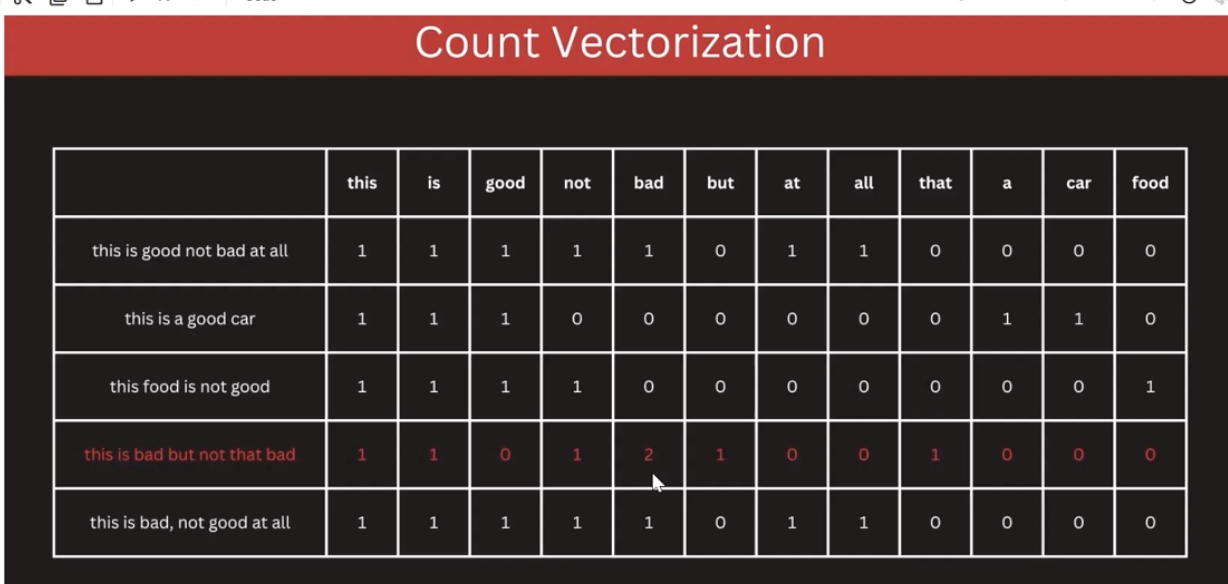

In [22]:
image = Image(filename='CountVectorization.png')
display(image)

In [23]:
# Using CountVectorizer without binary encoding for tweets
vec = CountVectorizer(binary = False)
vec = vec.fit(df['clean_tweets'])

# Encoding the tweets
enc_tweets = vec.fit_transform(df['clean_tweets']).toarray()

X_train,X_test, y_train,y_test = train_test_split(enc_tweets, df['labels'], test_size=0.2, random_state=42)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5)

model = Sequential()
model.add(Dense(512,activation = 'relu', input_shape = (enc_tweets.shape[1], )))
model.add(Dropout(.5))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(1,  activation = 'sigmoid'))

# Since, there are 2 output (Binary)
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

# Batch_size : How many tweets you want to pass to neural network at a time
history_2 = model.fit(X_train,y_train,epochs = epochs_, batch_size=batch_size_,validation_data = (X_val,y_val))

500/500 [==============================] - 13s 26ms/step - loss: 0.6018 - accuracy: 0.6752 - val_loss: 0.5386 - val_accuracy: 0.7350


In [24]:
model.evaluate(X_test,y_test)

63/63 [==============================] - 1s 11ms/step - loss: 0.5344 - accuracy: 0.7355


[0.5344103574752808, 0.7354999780654907]

### Neural Network with TF-IDF
* TF-IDF (Term Frequency-Inverse Document Frequency) combined with model training is a robust technique for text-based machine learning tasks. TF-IDF is used to transform raw text data into numerical features by considering both the frequency of terms in a document and their importance across the entire dataset. This method helps capture the significance of words in a document relative to the entire corpus. In the provided code snippet, TF-IDF is applied to preprocess and convert text data into a numerical format. Subsequently, a neural network model is constructed and trained using these TF-IDF representations as input features. This approach is particularly effective for tasks like sentiment analysis, providing a way to leverage the importance of words in text data for improved model performance.

* Values are in between range of 0s and 1s

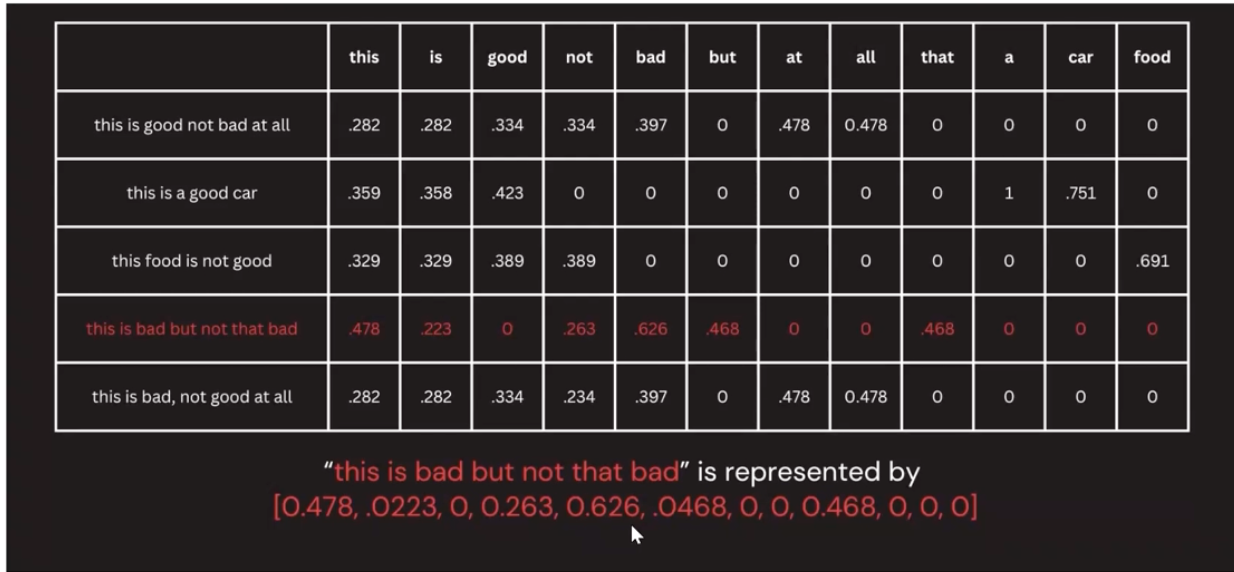

In [25]:
image = Image(filename='TfIdf.png')
display(image)

In [26]:
tfidf = TfidfVectorizer()

# Encoding the tweets
enc_tweets = tfidf.fit_transform(df['clean_tweets']).toarray()

X_train,X_test, y_train,y_test = train_test_split(enc_tweets, df['labels'], test_size=0.2, random_state=42)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5)

model = Sequential()
model.add(Dense(512,activation = 'relu', input_shape = (enc_tweets.shape[1], )))
model.add(Dropout(.5))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(1,  activation = 'sigmoid'))

# Since, there are 2 output (Binary)
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

# Batch_size : How many tweets you want to pass to neural network at a time
history_3 = model.fit(X_train,y_train,epochs = epochs_, batch_size=batch_size_,validation_data = (X_val,y_val))

500/500 [==============================] - 13s 25ms/step - loss: 0.5926 - accuracy: 0.6802 - val_loss: 0.5188 - val_accuracy: 0.7440


In [27]:
model.evaluate(X_test,y_test)

63/63 [==============================] - 0s 6ms/step - loss: 0.5360 - accuracy: 0.7240


[0.5360236763954163, 0.7239999771118164]

In [28]:
history_1.history

{'loss': [0.5974841713905334],
 'accuracy': [0.6778749823570251],
 'val_loss': [0.5444245934486389],
 'val_accuracy': [0.7404999732971191]}

### Neural Network with Index-based Encoding

* Neural networks for text sequences, like recurrent neural networks (RNNs), long short-term memory networks (LSTMs), and transformer-based models such as BERT, are pivotal in natural language processing. RNNs capture sequential dependencies, LSTMs handle long-term dependencies, and attention mechanisms (e.g., BERT) improve context understanding. Transfer learning, using pre-trained models, enhances efficiency in various tasks like sentiment analysis and machine translation. These models revolutionise language understanding and power diverse applications.

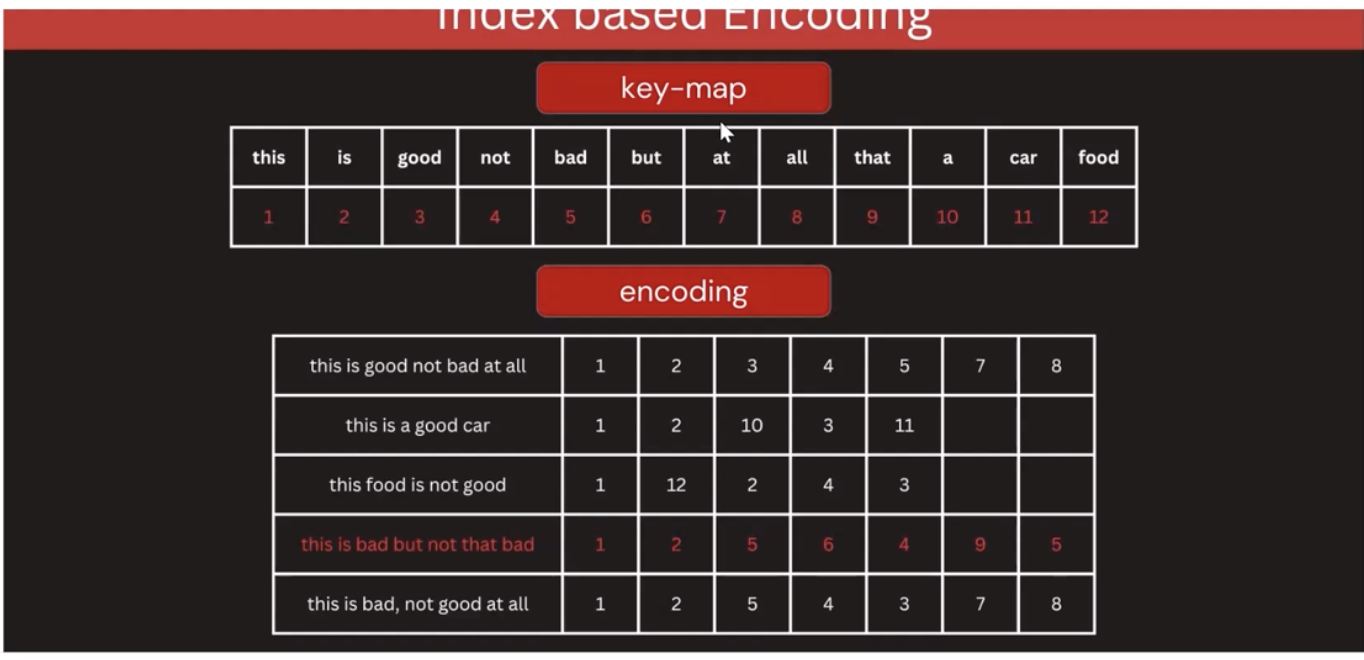

In [29]:
image = Image(filename='IndexBasedEncoding.png')
display(image)

# Converting text to sequences i.e every word associated to a number

In [37]:
epochs_ = 10
batch_size_ = 512
seq_len = 20

embedding_len_ = 50 # Each word is represented by 50 size

In [38]:
df = pd.read_csv("tweets.csv",encoding='latin',header=None,on_bad_lines='skip')
df.rename(columns = {0:'labels',5:'tweets'},inplace=True)
df.drop([1,2,3,4],axis=1,inplace=True)
df['labels'] = df['labels'].replace(4,1)

df = df.sample(frac=1)
df = df.head(100000)

df['clean_tweets'] = [preprocessed_tweet(tweet) for tweet in tqdm(df['tweets'], position =0,leave=True)]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [11:46<00:00, 141.61it/s]


In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_tweets'])

word_index = tokenizer.word_index
index_word = tokenizer.index_word

sequences = tokenizer.texts_to_sequences(df['clean_tweets'])
enc_tweets = pad_sequences(sequences,maxlen=seq_len,padding='post')

X_train,X_test, y_train,y_test = train_test_split(enc_tweets, df['labels'], test_size=0.2, random_state=42)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5)

model = Sequential()
model.add(Dense(512,activation = 'relu', input_shape = (seq_len,)))
model.add(Dropout(.5))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(1,  activation = 'sigmoid'))

# Since, there are 2 output (Binary)
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

# Batch_size : How many tweets you want to pass to neural network at a time
history_4 = model.fit(X_train,y_train,epochs = epochs_, batch_size=batch_size_,validation_data = (X_val,y_val))

Epoch 1/10
157/157 [==============================] - 1s 5ms/step - loss: 67.0488 - accuracy: 0.5031 - val_loss: 0.6936 - val_accuracy: 0.5011
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 2.6973 - accuracy: 0.4983 - val_loss: 0.6933 - val_accuracy: 0.5011
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 1.3547 - accuracy: 0.4986 - val_loss: 0.6931 - val_accuracy: 0.5011
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 0.9987 - accuracy: 0.4976 - val_loss: 0.6931 - val_accuracy: 0.4989
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 0.9749 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4989
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 0.7927 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.4989
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 0.7741 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4989
Epoch

In [40]:
enc_tweets.shape

(100000, 20)

In [41]:
len(word_index)

48865

* Neural Network works best (cannot work on large numbers) when data is close to zero. Therefore, we need to encode the data to 0s and 1s.
* We will convert it into word embedding


### Embedding Layer + Neural Network

* 1. Embedding in Text Sequences:

Embedding is a technique that transforms categorical variables, such as words in a text, into continuous vector representations. This helps capture semantic relationships between words.
Word embeddings, like Word2Vec, GloVe, or FastText, are pre-trained models that provide meaningful vector representations for words based on their context in large corpora.

In [42]:
model = Sequential()
# Go through dataset and create the embedding real time by going through dataset
model.add(Embedding(input_dim=len(word_index)+1, output_dim=embedding_len_, input_length=seq_len))
model.add(Flatten())

model.add(Dense(64,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))

model.add(Dense(1,  activation = 'sigmoid'))

# Since, there are 2 output (Binary)
model.compile(loss = 'binary_crossentropy',optimizer = Adam(learning_rate = 0.0001),metrics = ['accuracy'])

# Batch_size : How many tweets you want to pass to neural network at a time
history_5 = model.fit(X_train,y_train,epochs = epochs_, batch_size=batch_size_,validation_data = (X_val,y_val))

Epoch 1/10
157/157 [==============================] - 3s 14ms/step - loss: 0.6909 - accuracy: 0.5387 - val_loss: 0.6853 - val_accuracy: 0.5987
Epoch 2/10
157/157 [==============================] - 2s 13ms/step - loss: 0.6514 - accuracy: 0.6664 - val_loss: 0.5984 - val_accuracy: 0.7057
Epoch 3/10
157/157 [==============================] - 2s 12ms/step - loss: 0.5421 - accuracy: 0.7445 - val_loss: 0.5361 - val_accuracy: 0.7337
Epoch 4/10
157/157 [==============================] - 2s 12ms/step - loss: 0.4853 - accuracy: 0.7762 - val_loss: 0.5253 - val_accuracy: 0.7387
Epoch 5/10
157/157 [==============================] - 2s 12ms/step - loss: 0.4501 - accuracy: 0.7977 - val_loss: 0.5220 - val_accuracy: 0.7436
Epoch 6/10
157/157 [==============================] - 2s 11ms/step - loss: 0.4198 - accuracy: 0.8174 - val_loss: 0.5311 - val_accuracy: 0.7407
Epoch 7/10
157/157 [==============================] - 2s 12ms/step - loss: 0.3901 - accuracy: 0.8347 - val_loss: 0.5343 - val_accuracy: 0.7342

In [43]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 0s 548us/step - loss: 0.5684 - accuracy: 0.7366


[0.5684260725975037, 0.7365999817848206]

### Recurrent Neural Network

* RNNs are designed to handle sequential data, making them suitable for NLP tasks where context and order matter (e.g., language modeling, speech recognition).
* They maintain a hidden state that captures information from previous inputs, allowing them to consider context over time.


* Common weights and biases may result in exploding or vanishing gradient problem.

#### Types of RNN
1. 1-1 Architecture (1 i/p and 1 o/p and 1 node)
2. 1-N Architecture (1 i/p predict multiple output)
3. N-1 Architecture (multiple i/p predict 1 o/p)
4. N-N Architecture (multiple i/p and multiple o/p)

### Embedding + SimpleRNN

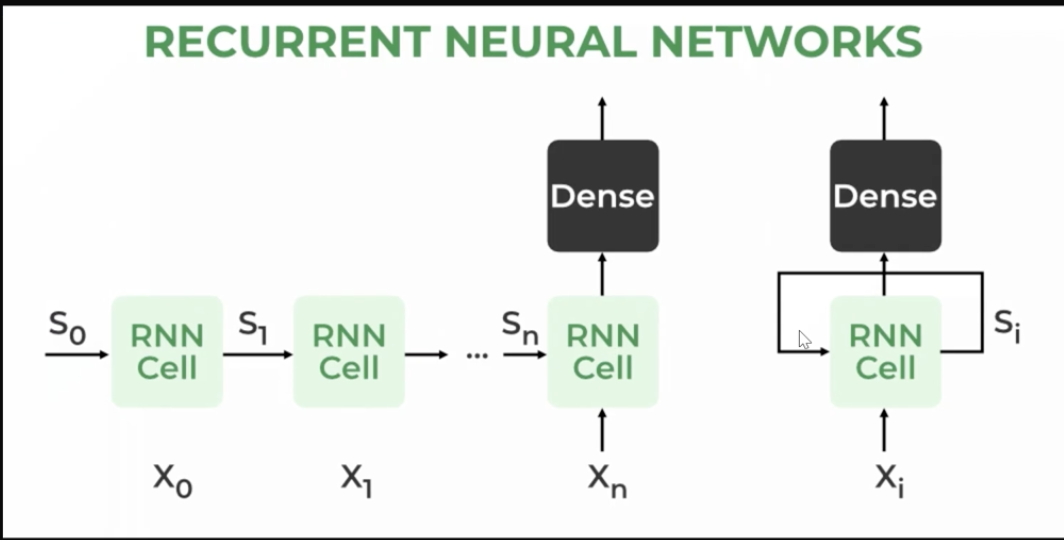

In [44]:
image = Image(filename='RNNStructure.png')
display(image)

In [45]:
from tensorflow.keras.layers import SimpleRNN

In [52]:
embedding_len_ = 100
epochs_ = 2
batch_size_ = 128
seq_len = 20

model = Sequential()

model.add(Embedding(input_dim=len(word_index)+1, output_dim=embedding_len_, input_length=seq_len))
model.add(SimpleRNN(units = 100,dropout=.2, return_sequences=True))
model.add(SimpleRNN(units=50))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,  activation = 'sigmoid'))

# Since, there are 2 output (Binary)
model.compile(loss = 'binary_crossentropy',optimizer = Adam(learning_rate = 0.0005),metrics = ['accuracy'])

history_6 = model.fit(X_train,y_train,epochs = epochs_, batch_size=batch_size_,validation_data = (X_val,y_val))

Epoch 1/2
625/625 [==============================] - 27s 39ms/step - loss: 0.6025 - accuracy: 0.6655 - val_loss: 0.5300 - val_accuracy: 0.7327
Epoch 2/2
625/625 [==============================] - 22s 35ms/step - loss: 0.4766 - accuracy: 0.7799 - val_loss: 0.5221 - val_accuracy: 0.7452


In [53]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.5145 - accuracy: 0.7477


[0.51445072889328, 0.7476999759674072]

### Long Short Term Memory

* There are 3 gates forget gate, input gate and output gate
* Forget Gate represent what percent of memory is to remember. It keeps track of the long term node.
* Input Gate : Having tan h and sigmoid activation function.
  - tan h : Keep track of potential short-term memory.
  - sigmoid : verify the potential value and take the actual value.

* Output Gate : Focuses on short term memory

Long Short-Term Memory Networks (LSTMs) and Gated Recurrent Units (GRUs):

- Variants of RNNs that address the vanishing gradient problem, allowing for better capture of long-range dependencies in sequential data.
- LSTMs and GRUs have mechanisms to selectively remember or forget information from the past.

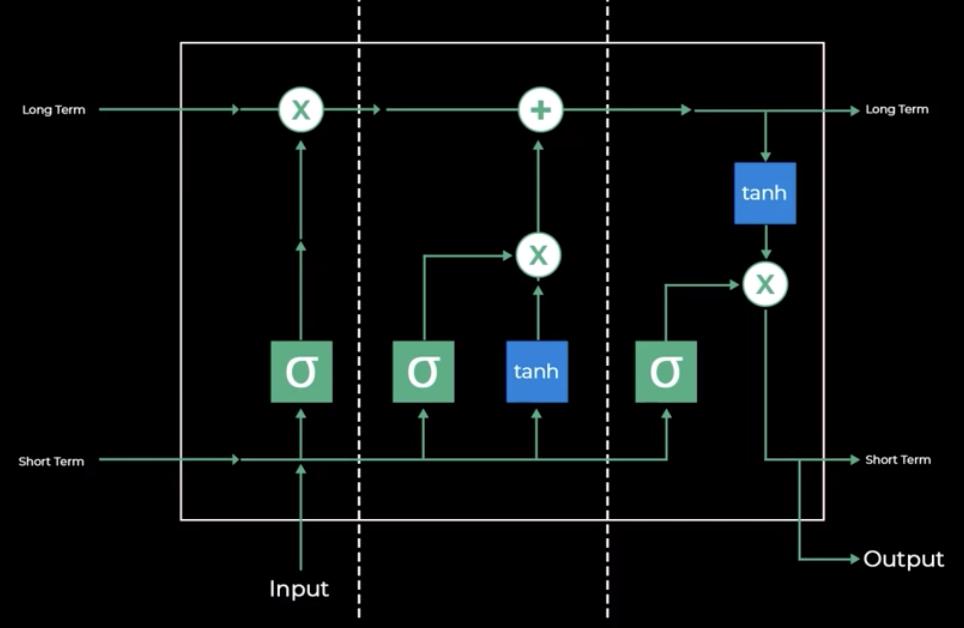

In [55]:
image = Image(filename='LSTM.png')
display(image)

### Embedding + LSTM

In [56]:
from tensorflow.keras.layers import LSTM

In [61]:
epochs_ = 1

model = Sequential()

model.add(Embedding(input_dim=len(word_index)+1, output_dim=embedding_len_, input_length=seq_len))

model.add(LSTM(units=100, dropout=0.2, return_sequences=True))
model.add(LSTM(units=50))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,  activation = 'sigmoid'))

# Since, there are 2 output (Binary)
model.compile(loss = 'binary_crossentropy',optimizer = Adam(learning_rate = 0.0005),metrics = ['accuracy'])

history_7 = model.fit(X_train,y_train,epochs = epochs_, batch_size=batch_size_,validation_data = (X_val,y_val))

625/625 [==============================] - 41s 61ms/step - loss: 0.5622 - accuracy: 0.7034 - val_loss: 0.5122 - val_accuracy: 0.7484


In [62]:
model.evaluate(X_test,y_test)
# Greater the batch size lesser the training time

313/313 [==============================] - 2s 6ms/step - loss: 0.5039 - accuracy: 0.7540


[0.5038818120956421, 0.7540000081062317]

### Gated Recurrent Unit (GRU)
* Having 2 gates: update gate and reset gate.
* Update Gate : Tells how much of past memory to retain.
* Reset Gate : How much of past memory to forget.


#### Embedding + GRU

In [66]:
from tensorflow.keras.layers import GRU

In [70]:
epochs_ = 2

model = Sequential()

model.add(Embedding(input_dim=len(word_index)+1, output_dim=embedding_len_, input_length=seq_len))

model.add(GRU(units=100,dropout=0.2, return_sequences=True))
model.add(GRU(units=50))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,  activation = 'sigmoid'))

# Since, there are 2 output (Binary)
model.compile(loss = 'binary_crossentropy',optimizer = Adam(learning_rate = 0.0005),metrics = ['accuracy'])

history_8 = model.fit(X_train,y_train,epochs = epochs_, batch_size=batch_size_,validation_data = (X_val,y_val))

Epoch 1/2
625/625 [==============================] - 37s 55ms/step - loss: 0.6333 - accuracy: 0.5976 - val_loss: 0.5233 - val_accuracy: 0.7424
Epoch 2/2
625/625 [==============================] - 33s 53ms/step - loss: 0.4860 - accuracy: 0.7741 - val_loss: 0.5165 - val_accuracy: 0.7493


In [71]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.5051 - accuracy: 0.7541


[0.5050536394119263, 0.7541000247001648]

### Bi- Directional Layer
* Is an architecture works on LSTM, RNN , GRU
![Bidirectional Layer](BiDirectional.png)

### Embedding + Bidirectional + GRU

In [72]:
from tensorflow.keras.layers import Bidirectional

In [73]:
epochs_ = 2

model = Sequential()

model.add(Embedding(input_dim=len(word_index)+1, output_dim=embedding_len_, input_length=seq_len))

model.add(Bidirectional(GRU(units=100,dropout=0.2, return_sequences=True)))
model.add(Bidirectional(GRU(units=50)))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,  activation = 'sigmoid'))

# Since, there are 2 output (Binary)
model.compile(loss = 'binary_crossentropy',optimizer = Adam(learning_rate = 0.0005),metrics = ['accuracy'])

history_9 = model.fit(X_train,y_train,epochs = epochs_, batch_size=batch_size_,validation_data = (X_val,y_val))

Epoch 1/2
625/625 [==============================] - 55s 80ms/step - loss: 0.5603 - accuracy: 0.7060 - val_loss: 0.5181 - val_accuracy: 0.7435
Epoch 2/2
625/625 [==============================] - 48s 78ms/step - loss: 0.4512 - accuracy: 0.7963 - val_loss: 0.5151 - val_accuracy: 0.7453


In [74]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.5005 - accuracy: 0.7539


[0.500495970249176, 0.7538999915122986]

### Embedding + Bidirectional + LSTM

In [113]:
from keras.callbacks import EarlyStopping
epochs_ = 2

model = Sequential()

model.add(Embedding(input_dim=len(word_index)+1, output_dim=embedding_len_, input_length=seq_len))

model.add(Bidirectional(LSTM(units=100,dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(units=50)))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,  activation = 'sigmoid'))

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Since, there are 2 output (Binary)
model.compile(loss = 'binary_crossentropy',optimizer = Adam(learning_rate = 0.0005),metrics = ['accuracy'])

history_10 = model.fit(X_train,y_train,epochs = epochs_, batch_size=batch_size_,validation_data = (X_val,y_val),
                     callbacks=[early_stopping])



Epoch 1/2
313/313 [==============================] - 47s 135ms/step - loss: 0.5753 - accuracy: 0.6942 - val_loss: 0.5209 - val_accuracy: 0.7430
Epoch 2/2
313/313 [==============================] - 40s 126ms/step - loss: 0.4649 - accuracy: 0.7898 - val_loss: 0.5213 - val_accuracy: 0.7442


In [92]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.5055 - accuracy: 0.7501


[0.5054996013641357, 0.7501000165939331]

### Neural Network with Custom Word2Vec

#### 4.1 Custom Word2Vec with Conv1D | Previous Best
#### 4.1 .1 ) Loading the Dataset

In [108]:
epochs_       = 12
seq_len       = 20
batch_size_   = 256
training_size = .8
embedding_len = 100

df = pd.read_csv('tweets.csv',encoding='latin',header=None,on_bad_lines='skip')
df.rename(columns={0:'labels',5:'tweets'}, inplace=True)
df.drop([1,2,3,4],axis=1,inplace=True)

df['labels'] = df['labels'].replace(4,1)

df = df.sample(frac=1)
#df = df.head(20000)

df['clean_tweets'] = [preprocessed_tweet(tweet) for tweet in tqdm(df['tweets'], position=0, leave=True)]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_tweets'])

sequences = tokenizer.texts_to_sequences(df['clean_tweets'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1600000/1600000 [3:06:26<00:00, 143.03it/s]


#### 4.1.2) Training the Word2Vec

In [109]:
word2vec = Word2Vec(list(map(lambda x:word_tokenize(x), df['clean_tweets'])),
                    vector_size = embedding_len,
                    workers = 8,
                    min_count = 1)
print('Vocabulary Size:',len(word2vec.wv.key_to_index))

Vocabulary Size: 306688


#### 4.1.3) Creating Embedding Matrix

In [110]:
embedding_matrix = np.zeros((len(word2vec.wv.key_to_index), embedding_len))

for word, token in tokenizer.word_index.items():
    if word2vec.wv.__contains__(word):
        embedding_matrix[token] = word2vec.wv.__getitem__(word)

print('Embedding Matrix Shape',embedding_matrix.shape)

Embedding Matrix Shape (306688, 100)


#### 4.1.4) Training the Neural Network

In [111]:
from keras.layers import Conv1D, GlobalMaxPooling1D

In [112]:
model = Sequential()
# Use embedding matrix as weights it is not randomly initialized
model.add(Embedding(input_dim=len(word2vec.wv.key_to_index), output_dim=embedding_len,
                   weights = [embedding_matrix], input_length = seq_len, trainable = False))
model.add(Conv1D(128,5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

history_11 = model.fit(X_train,y_train,epochs =epochs_,batch_size=batch_size_, validation_data=(X_val,y_val))
print('\n')
print('Model Evaluation on Testing Data: ',round(model.evaluate(X_test,y_test)[1]*100,2))

Epoch 1/12
313/313 [==============================] - 5s 13ms/step - loss: 0.7340 - accuracy: 0.5361 - val_loss: 0.6703 - val_accuracy: 0.5952
Epoch 2/12
313/313 [==============================] - 4s 12ms/step - loss: 0.6658 - accuracy: 0.5913 - val_loss: 0.6490 - val_accuracy: 0.6213
Epoch 3/12
313/313 [==============================] - 4s 12ms/step - loss: 0.6409 - accuracy: 0.6252 - val_loss: 0.6303 - val_accuracy: 0.6400
Epoch 4/12
313/313 [==============================] - 4s 12ms/step - loss: 0.6186 - accuracy: 0.6477 - val_loss: 0.6165 - val_accuracy: 0.6545
Epoch 5/12
313/313 [==============================] - 4s 12ms/step - loss: 0.6003 - accuracy: 0.6676 - val_loss: 0.6065 - val_accuracy: 0.6620
Epoch 6/12
313/313 [==============================] - 4s 12ms/step - loss: 0.5856 - accuracy: 0.6802 - val_loss: 0.5992 - val_accuracy: 0.6712
Epoch 7/12
313/313 [==============================] - 4s 12ms/step - loss: 0.5728 - accuracy: 0.6934 - val_loss: 0.5947 - val_accuracy: 0.6774

#### 4.2 Custom Word2Vec with Bidirectional + LSTM

In [115]:
model = Sequential()
# Use embedding matrix as weights it is not randomly initialized
model.add(Embedding(input_dim=len(word2vec.wv.key_to_index), output_dim=embedding_len,
                   weights = [embedding_matrix], input_length = seq_len, trainable = False))

model.add(Bidirectional(LSTM(units=100,dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(units=100,dropout=0.3, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

history_12 = model.fit(X_train,y_train,epochs =epochs_,batch_size=batch_size_, validation_data=(X_val,y_val))
print('\n')
print('Model Evaluation on Testing Data: ',round(model.evaluate(X_test,y_test)[1]*100,2))

Epoch 1/2
313/313 [==============================] - 50s 144ms/step - loss: 0.6714 - accuracy: 0.5839 - val_loss: 0.6355 - val_accuracy: 0.6365
Epoch 2/2
313/313 [==============================] - 44s 140ms/step - loss: 0.6309 - accuracy: 0.6411 - val_loss: 0.5947 - val_accuracy: 0.6768


313/313 [==============================] - 4s 11ms/step - loss: 0.5930 - accuracy: 0.6754
Model Evaluation on Testing Data:  67.54
